#### Masked Language Models

Solved excercise 

**Imports: Import necessary libraries**

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, metrics, Model
import json
import numpy as np
import os
import warnings
import pandas as pd
import json
import umap.umap_ as umap
import plotly.express as px

- **TokenAndPositionEmbedding Class:**
    - Combines token and positional embeddings.
    - token_emb embeds the input tokens, while pos_emb embeds the positions.
    - The call method adds these embeddings together.
- **TransformerBlock Class:**
    - Implements a basic transformer block with multi-head attention and a feed-forward network (FFN).
    - Layer normalization and dropout are applied for regularization.
    - The call method combines these layers.
- **get_masked_language_model Function:**
    - Constructs a masked language model using the previously defined layers.
    - Compiles the model with Adam optimizer and sparse categorical cross-entropy loss.
    - Returns the compiled model and the output of the transformer block.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, metrics, Model

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        # Token embedding layer
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Positional embedding layer
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Calculate maximum sequence length dynamically
        maxlen = tf.shape(x)[-1]
        # Generate positions tensor from 0 to maxlen
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Apply positional embedding
        positions = self.pos_emb(positions)
        # Apply token embedding
        x = self.token_emb(x)
        # Add token and positional embeddings
        return x + positions

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, **kwarg):
        super(TransformerBlock, self).__init__(**kwarg)
        # Multi-head attention mechanism
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed-forward neural network
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        # Layer normalization after the first sub-layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        # Layer normalization after the second sub-layer
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        # Dropout layer after the first sub-layer
        self.dropout1 = layers.Dropout(0.1)
        # Dropout layer after the second sub-layer
        self.dropout2 = layers.Dropout(0.1)

    def call(self, inputs, training):
        # Multi-head self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout during training
        attn_output = self.dropout1(attn_output, training=training)
        # Residual connection and layer normalization
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward network
        ffn_output = self.ffn(out1)
        # Apply dropout during training
        ffn_output = self.dropout2(ffn_output, training=training)
        # Residual connection and layer normalization
        return self.layernorm2(out1 + ffn_output)

def get_masked_language_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim):
    # Input layer with shape (maxlen,)
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    # Token and positional embedding layer
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    # Transformer block
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    # Apply transformer block to input
    x = transformer_block(x, training=True)
    # Layer normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    # Output layer
    output_layer = layers.Dense(vocab_size)
    # Generate model with inputs and outputs
    outputs = output_layer(x)
    model = Model(inputs=inputs, outputs=outputs)
    # Compile model with optimizer, loss function, and metrics
    model.compile(
        optimizer=optimizers.Adam(),
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[metrics.SparseCategoricalAccuracy()]
    )

    return model, x


- **get_vocab_size Function:**
    - Builds a vocabulary from the sequences.
    - Adds special tokens (<pad>, <sos>, <eos>, <mask>).
    - Returns the vocabulary size and token dictionary.
- **get_tokenized_inputs Function:**
    - Converts sequences to tokenized inputs using the vocabulary.
    - Adds <sos> at the beginning and <eos> at the end.
    - Returns the tokenized inputs.
- **get_masked_tokenized_inputs Function:**
    - Masks a percentage of tokens in the sequences based on a given probability.
    - Returns the masked tokenized inputs.
- **pad_processed_data Function:**
    - Pads tokenized sequences to a fixed maximum length.
    - Ensures all sequences are of the same length.
    - Returns the padded tokenized and masked inputs.
- **get_train_test_split Function:**
    - Splits the data into training, testing, and unseen sets.
    - Returns a dictionary with train and test inputs and their corresponding masked versions.

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

def get_vocab_size(df_sequences):
    """
    Computes the vocabulary size and creates a dictionary of tokens from the sequences.

    Args:
    - df_sequences (dict): Dictionary containing sequences of tokens.

    Returns:
    - vocab_size (int): Number of distinct tokens in the vocabulary.
    - df_tokens (dict): Dictionary mapping tokens to unique integer indices.
    """
    # Initialize token dictionary with special tokens
    df_tokens = {
        "<pad>": 0,
        "<sos>": 1,
        "<eos>": 2,
        "<mask>": 3,
    }
    # Collect all unique tokens from sequences
    activity_set = set()
    for key in df_sequences.keys():
        activity_set.update(df_sequences[key])
    
    # Assign unique indices to each token
    token = 4
    for activity in activity_set:
        df_tokens[activity] = token
        token += 1
    
    # Calculate the total number of tokens (vocabulary size)
    vocab_size = len(df_tokens.keys())
    
    return vocab_size, df_tokens


def get_tokenized_inputs(df_sequences, df_tokens):
    """
    Converts sequences of tokens into tokenized inputs using the provided token dictionary.

    Args:
    - df_sequences (dict): Dictionary containing sequences of tokens.
    - df_tokens (dict): Dictionary mapping tokens to unique integer indices.

    Returns:
    - df_tokenized_inputs (dict): Dictionary mapping case IDs to tokenized input sequences.
    """
    df_tokenized_inputs = {}
    for key in df_sequences.keys():
        sequence = df_sequences[key]
        # Start of sequence token
        tokenized_input = [df_tokens["<sos>"]]  
        for word in sequence:
            tokenized_input.append(df_tokens[word])
        # End of sequence token    
        tokenized_input.append(df_tokens["<eos>"])  
        df_tokenized_inputs[key] = tokenized_input
        return df_tokenized_inputs


def get_masked_tokenized_inputs(df_tokenized_inputs, masking_probability, df_tokens):
    """
    Masks tokenized inputs based on a given masking probability using the token dictionary.

    Args:
    - df_tokenized_inputs (dict): Dictionary mapping case IDs to tokenized input sequences.
    - masking_probability (float): Probability of masking each token.
    - df_tokens (dict): Dictionary mapping tokens to unique integer indices.

    Returns:
    - df_masked_tokenized_inputs (dict): Dictionary mapping case IDs to masked tokenized input sequences.
    """
    df_masked_tokenized_inputs = {}
    for key in df_tokenized_inputs.keys():
        sequence = df_tokenized_inputs[key][1:][:-1]  # Exclude <sos> and <eos> tokens from masking
        mask = np.random.rand(len(sequence)) < masking_probability
        sequence_masked = np.where(mask, df_tokens["<mask>"], sequence).tolist()
        sequence_masked = [df_tokens["<sos>"]] + sequence_masked + [df_tokens["<eos>"]]
        df_masked_tokenized_inputs[key] = sequence_masked
    
    return df_masked_tokenized_inputs


def pad_processed_data(maxlen, df_tokens, df_tokenized_inputs, df_masked_tokenized_inputs):
    """
    Pads tokenized and masked inputs to a fixed length (maxlen) using padding tokens.

    Args:
    - maxlen (int): Maximum length to pad sequences to.
    - df_tokens (dict): Dictionary mapping tokens to unique integer indices.
    - df_tokenized_inputs (dict): Dictionary mapping case IDs to tokenized input sequences.
    - df_masked_tokenized_inputs (dict): Dictionary mapping case IDs to masked tokenized input sequences.

    Returns:
    - df_tokenized_inputs_padded (dict): Dictionary mapping case IDs to padded tokenized input sequences.
    - df_masked_tokenized_inputs_padded (dict): Dictionary mapping case IDs to padded masked tokenized input sequences.
    """
    df_tokenized_inputs_padded = {}
    df_masked_tokenized_inputs_padded = {}

    for key in df_tokenized_inputs.keys():
        # Pad tokenized inputs
        sequence = df_tokenized_inputs[key]
        if len(sequence) < maxlen:
            sequence = sequence + [df_tokens["<pad>"]] * (maxlen - len(sequence))
        df_tokenized_inputs_padded[key] = sequence

        # Pad masked tokenized inputs
        sequence = df_masked_tokenized_inputs[key]
        if len(sequence) < maxlen:
            sequence = sequence + [df_tokens["<pad>"]] * (maxlen - len(sequence))
        df_masked_tokenized_inputs_padded[key] = sequence

    return df_tokenized_inputs_padded, df_masked_tokenized_inputs_padded


def get_train_test_split(df_tokenized_inputs_padded, df_masked_tokenized_inputs_padded):
    """
    Splits data into training and test sets based on tokenized and masked tokenized inputs.

    Args:
    - df_tokenized_inputs_padded (dict): Dictionary mapping case IDs to padded tokenized input sequences.
    - df_masked_tokenized_inputs_padded (dict): Dictionary mapping case IDs to padded masked tokenized input sequences.

    Returns:
    - df_train_test (dict): Dictionary containing 'train_input', 'train_masked', 'test_input', 'test_masked' splits.
    """
    case_ids = list(df_tokenized_inputs_padded.keys())

    # Split case IDs into training, test, and unseen sets
    train_split, temp_split, _, _ = train_test_split(case_ids, case_ids, test_size=0.3)
    test_split, unseen_split, _, _ = train_test_split(temp_split, temp_split, test_size=0.3)

    # Store split case IDs
    df_split = {
        "train_split": train_split,
        "test_split": test_split,
        "unseen_split": unseen_split
    }

    # Create dictionaries for train and test sets
    df_train_test = {
        "train_input": [], "train_masked": [],
        "test_input": [], "test_masked": []
    }

    # Populate train and test dictionaries with padded inputs
    for key in ["train", "test"]:
        for case_id in df_split[key+"_split"]:
            df_train_test[key+"_input"].append(df_tokenized_inputs_padded[case_id])
            df_train_test[key+"_masked"].append(df_masked_tokenized_inputs_padded[case_id])

    return df_train_test


### **Training the model**
- Load sequence data and define max sequence length.
- Create a vocabulary and tokenize the sequences.
- Mask a portion of the tokens to prepare for masked language model training.
- Pad the sequences to ensure uniform input size for the model.
- Split the data into training and testing sets.
- Define and create the masked language model with the specified architecture.
- Train the model on the masked data, using original sequences as targets.
- Extract the encoder part of the trained model to generate embeddings.
- Generate and save embeddings for each sequence in the dataset.

In [70]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging for cleaner output
warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output
# Load the sequences data from a JSON file
with open("data/sequences.json") as f:
    df_sequences = json.load(f)

# Define the maximum length for sequences
maxlen = 32

# Get the vocabulary size and token mapping from the sequences
vocab_size, df_tokens = get_vocab_size(df_sequences)

# Tokenize the input sequences using the vocabulary
df_tokenized_inputs = get_tokenized_inputs(df_sequences, df_tokens)

# Define the masking probability for creating masked language model inputs
masking_probability = 0.2  # 20%
# Generate masked tokenized inputs based on the masking probability
df_masked_tokenized_inputs = get_masked_tokenized_inputs(df_tokenized_inputs, masking_probability, df_tokens)

# Pad the tokenized inputs and masked inputs to the maximum length
df_tokenized_inputs_padded, df_masked_tokenized_inputs_padded = pad_processed_data(maxlen, df_tokens, df_tokenized_inputs, df_masked_tokenized_inputs)

# Split the data into training and testing sets
df_train_test = get_train_test_split(df_tokenized_inputs_padded, df_masked_tokenized_inputs_padded)

# Define the model architecture parameters
embed_dim = maxlen
ff_dim = 128
num_heads = 4

# Create the masked language model
model, x = get_masked_language_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim)

# Define training parameters
epochs = 10
batch_size = 12

# Train the model using the training data and validate on the test data
model.fit(np.array(df_train_test["train_masked"]), np.array(df_train_test["train_input"]), 
          epochs=epochs, batch_size=batch_size, 
          validation_data=(np.array(df_train_test["test_masked"]), np.array(df_train_test["test_input"])))

# Create an encoder model that outputs the encoded vectors from the masked language model
encoder = Model(inputs=model.input, outputs=x)

# Generate embeddings for each tokenized input sequence
df_embeddings = {}
for key in df_tokenized_inputs_padded.keys():
    input_data = df_tokenized_inputs_padded[key]
    input_data = tf.expand_dims(input_data, 0)  # Expand dimensions to match model input
    encoded_vector = encoder.predict(input_data)  # Predict encoded vector using the encoder model
    avg_output = np.mean(encoded_vector, axis=1)  # Compute average vector for the sequence
    df_embeddings[key] = avg_output[0].tolist()  # Store the average vector in the embeddings dictionary

# Save the embeddings to a JSON file
with open("data/embeddings.json", "w") as f:
    json.dump(df_embeddings, f)


Epoch 1/10
268/268 [==============================] - 7s 11ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.0343 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/10
268/268 [==============================] - 2s 9ms/step - loss: 0.0299 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.0290 - val_sparse_categorical_accuracy: 0.9910
Epoch 3/10
268/268 [==============================] - 2s 8ms/step - loss: 0.0203 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.0167 - val_sparse_categorical_accuracy: 0.9955
Epoch 4/10
268/268 [==============================] - 2s 9ms/step - loss: 0.0157 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0146 - val_sparse_categorical_accuracy: 0.9963
Epoch 5/10
268/268 [==============================] - 2s 8ms/step - loss: 0.0136 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0196 - val_sparse_categorical_accuracy: 0.9918
Epoch 6/10
268/268 [==============================] - 3s 9ms/step - loss: 0.0132 - sparse_categoric

### Ploting the embedding

mapping
mapped
extracting data
plotting


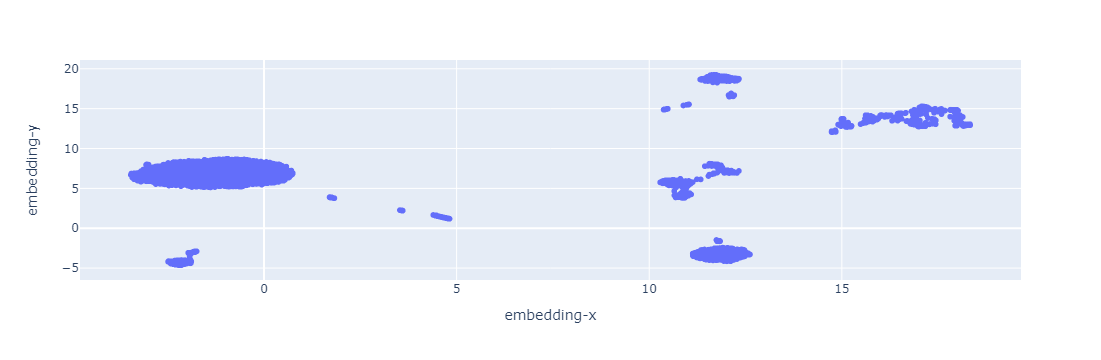

In [71]:
# Load the embeddings from the JSON file
with open("data/embeddings.json") as f:
    df_embeddings = json.load(f)

# Load the sequences from the JSON file
with open("data/sequences.json", encoding="utf8") as f:
    df_sequences = json.load(f)

# Perform dimensionality reduction using UMAP to map high-dimensional embeddings to 2D points
print("mapping")
points = umap.UMAP(n_components=2).fit_transform(np.array(list(df_embeddings.values()))).tolist()
print("mapped")

# Extract case IDs from the embeddings dictionary
case_ids = list(df_embeddings.keys())

# Create a dictionary to store 2D points for each case ID
df_points = {}
for i in range(len(case_ids)):
    df_points[case_ids[i]] = points[i]

# Initialize lists to store data for DataFrame creation
case_ids = []
sequences = []
embeddings_x = []
embeddings_y = []

# Extract data from embeddings and sequences dictionaries
print("extracting data")
for case_id in df_embeddings.keys():
    case_ids.append(case_id)
    embeddings_x.append(df_points[case_id][0])
    embeddings_y.append(df_points[case_id][1])
    sequences.append(df_sequences[case_id])

# Create a DataFrame to hold the extracted data
df = pd.DataFrame({"id":case_ids, "embedding-x":embeddings_x, "embedding-y":embeddings_y, "sequences":sequences})

# Plot the data using Plotly for an interactive scatter plot
print("plotting")
fig = px.scatter(df, x='embedding-x', y='embedding-y', custom_data=["sequences"])
fig.update_traces(hovertemplate="<br>".join(["%{customdata[0]}"]))
fig.show()

### Predicting masked words

In [72]:
# In case of need to use vocab_size, df_tokens just uncomment the code bellow 
# vocab_size, df_tokens = get_vocab_size(df_sequences)

# Create a reverse dictionary to convert tokens back to words
reverse_df_tokens = {v: k for k, v in df_tokens.items()}

def tokenize_and_pad_sequence(sequence, df_tokens, maxlen):
    # Add start-of-sequence token
    tokenized_input = [df_tokens["<sos>"]] 
    
    # Convert each word in the sequence to its corresponding token id
    tokenized_input += [df_tokens.get(word, df_tokens["<pad>"]) for word in sequence] 
    
    # Add end-of-sequence token
    tokenized_input.append(df_tokens["<eos>"])
    
    # Pad the sequence if it is shorter than maxlen
    if len(tokenized_input) < maxlen:
        tokenized_input = tokenized_input + [df_tokens["<pad>"]] * (maxlen - len(tokenized_input))
    
    # Truncate the sequence if it is longer than maxlen
    return tokenized_input[:maxlen]
    
def predict_masked_word(sequence, model, df_tokens, reverse_df_tokens, maxlen):
    # Tokenize and pad the input sequence
    tokenized_input = tokenize_and_pad_sequence(sequence, df_tokens, maxlen)
    
    # Expand dimensions to match the model input shape (batch size, sequence length)
    input_data = np.expand_dims(tokenized_input, 0)
    
    # Get predictions from the model
    predictions = model.predict(input_data)
    
    # Get the token ids with the highest probability for each position in the sequence
    predicted_token_ids = np.argmax(predictions, axis=-1)[0]
    
    # Convert token ids back to words
    predicted_sequence = [reverse_df_tokens[token_id] for token_id in predicted_token_ids]
    
    return predicted_sequence


# Example usage with a masked sequence
# The masked sentence is <Take in charge ticket>
masked_sequence = ["Assign seriousness", "<mask>", "Take in charge ticket", "Resolve ticket", "closed"]  # input sentence with masked word
predicted_sequence = predict_masked_word(masked_sequence, model, df_tokens, reverse_df_tokens, maxlen)
print("Original Sequence:", " ".join(masked_sequence))
print("Predicted Sequence:", " ".join(predicted_sequence))


1/1 [==============================] - 0s 284ms/step
Original Sequence: Assign seriousness <mask> Take in charge ticket Resolve ticket closed
Predicted Sequence: <sos> Assign seriousness Take in charge ticket Take in charge ticket Resolve ticket <pad> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging for cleaner output
warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output
# Load the sequences data from a JSON file
with open("data/sequences.json") as f:
    df_sequences = json.load(f)

# Define the maximum length for sequences
maxlen = 32

# Get the vocabulary size and token mapping from the sequences
vocab_size, df_tokens = get_vocab_size(df_sequences)

# Tokenize the input sequences using the vocabulary
df_tokenized_inputs = get_tokenized_inputs(df_sequences, df_tokens)

In [7]:
df_tokens

{'<pad>': 0,
 '<sos>': 1,
 '<eos>': 2,
 '<mask>': 3,
 'Resolve ticket': 4,
 'Assign seriousness': 5,
 'Require upgrade': 6,
 'Schedule intervention': 7,
 'Insert ticket': 8,
 'Resolve SW anomaly': 9,
 'VERIFIED': 10,
 'RESOLVED': 11,
 'INVALID': 12,
 'Wait': 13,
 'DUPLICATE': 14,
 'Create SW anomaly': 15,
 'Closed': 16,
 'Take in charge ticket': 17}